<a href="https://colab.research.google.com/github/Ryukijano/Qiskit_on_Qubit/blob/main/quantumGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GENERATIVE ADVERSARIAL NETWORKS (GANs)
The goal of generative adversarial networks (GANs)  is to generate data that resembles the original data used in training. To achieve this, we train two neural networks simulatenously: a generator and a discriminator. The job of the generator is to create fake data which imitates the real training dataset. On the otherhand, the discriminator acts like a detective trying to discern real from fake data. During the training process, both players iteratively improve with one another. By the end, the generator should hopefully generate new data very similar to the training dataset.

Specifically, the training dataset represents samples drawn from some unknown data distribution Pdata, and the generator has the job of trying to capture this distribution.The generator, G, starts from some initial latent distribution, Pz, and maps it to Pg=G(Pz). The best solution would be for Pg=Pdata. However, this point is rarely achieved in practice apart from in the most simple tasks.

Both the discriminator, D, and generator, G, play in a 2-player minimax game. The discriminator tries to maximise the probability of discerning real from fake data, while the generator tries to minimise the same probability. The value function for the game is summarised by,


minGmaxDV(D,G)=Ex∼pdata[logD(x) + Ez∼pz[log(1−D(G(z))]

. x : real data sample
. z : latent vector
. D(x): probability of discriminator classifying fake data as real.

In practice, the two networks are trained iteratively, each with a separate loss function to be minimised,

LD=−[y⋅log(D(x))+(1−y)⋅log(1−D(G(z)))]

LG=[(1−y)⋅log(1−D(G(z)))]

where y is a binary label for real (y=1) or fake(y=0) data.In practice, generator training is shown to be more stable when made to maximise log(D(G(z))) instead of a minimising log(1-D(G(z))). Hence, the generator loss function to be minimised becomes,
    LG= - [(1-y).log(D(G(z)))]


QUANTUM GANs: The Patch Method
We re-create one of the quantum GAN methods presented by Huang : the patch method. This method uses several quantum generators, with each sub-generator, G(i), responsible for constructing a small patch of the final image. The final image is constructed by concatenting all of the patches.
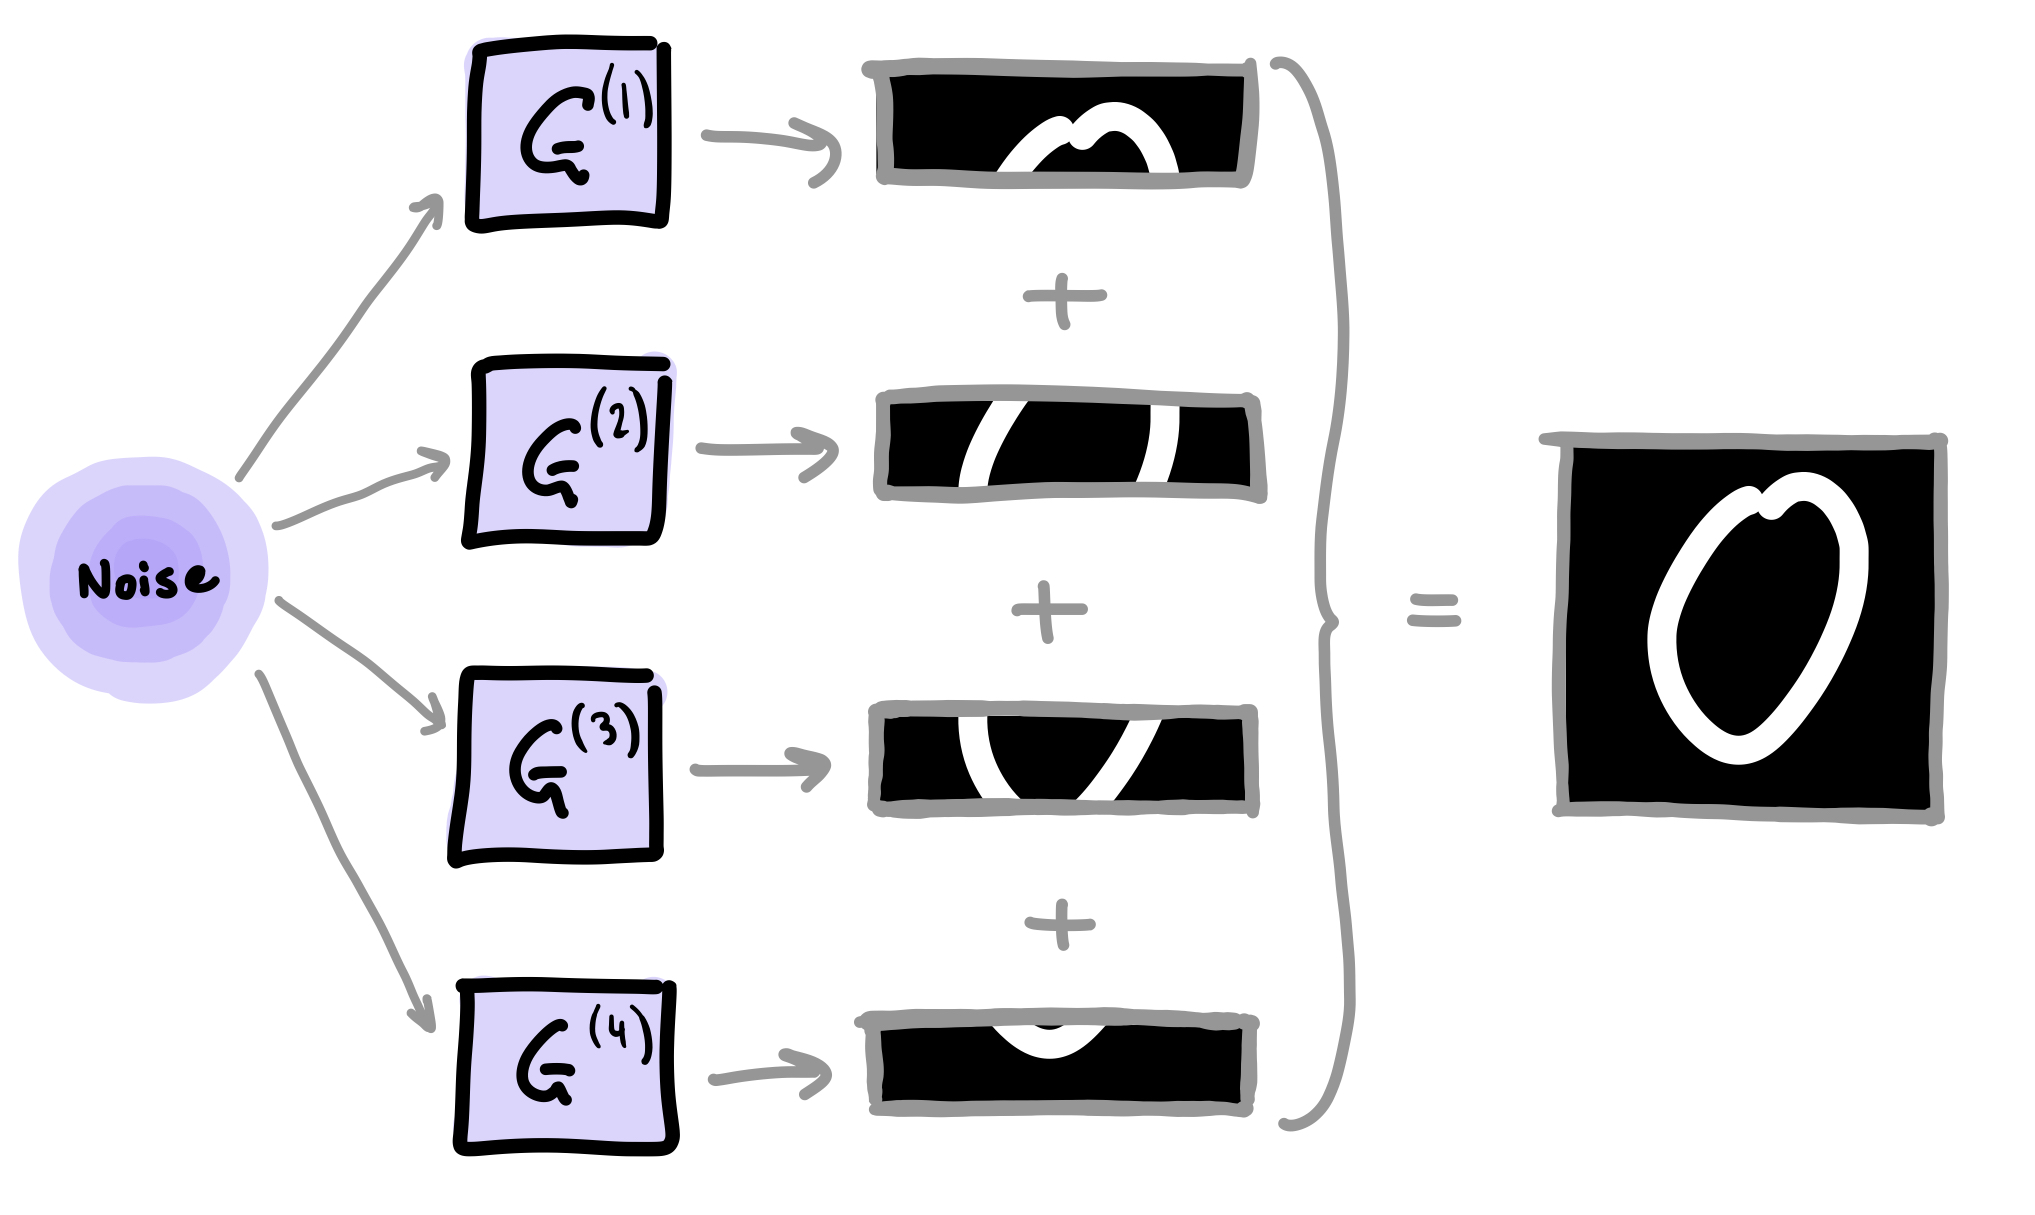

The main advantage of this method is that it is particularly  suited to situations where the unmber of available qubits are limited. The same quantum device can be used for each sub-generator in an iterative fashion, or execution of the generators can be parallelized across multiple devices.


Module Imports

In [1]:
!pip install pennylane

In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Data:-
We use a small dataset of handwritten zeros. First, we need to create a custom dataloader for this dataset.

In [3]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

Next we define some variables and create the dataloader instance

In [4]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="/content/optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

# New Section

Let's visualize some of the data

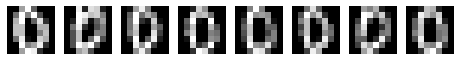

In [5]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

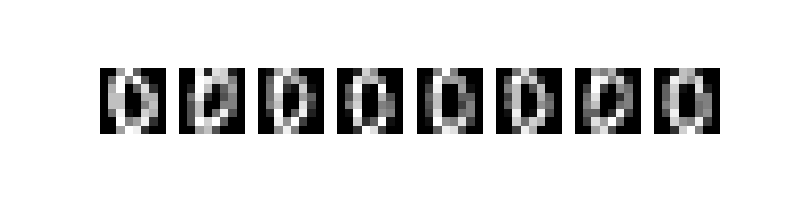

Implementing the Discriminator
For the discriminator, we use a fully connected neural network with two hidden layers. A single output is sufficient to represent the probability of an input being classified as real.

In [6]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

Implementing the Generator
Each sub-generator, 
G(i), shares the same circuit architecture as shown below. The overall quantum generator consists of NG sub-generators, each consisting of N qubits. The process from latent vector input to image output can be split into four distinct sections: state embedding, parameterisation, non-linear transformation, and post-processing. Each of the following sections below refer to a single iteration of the training process to simplify the discussion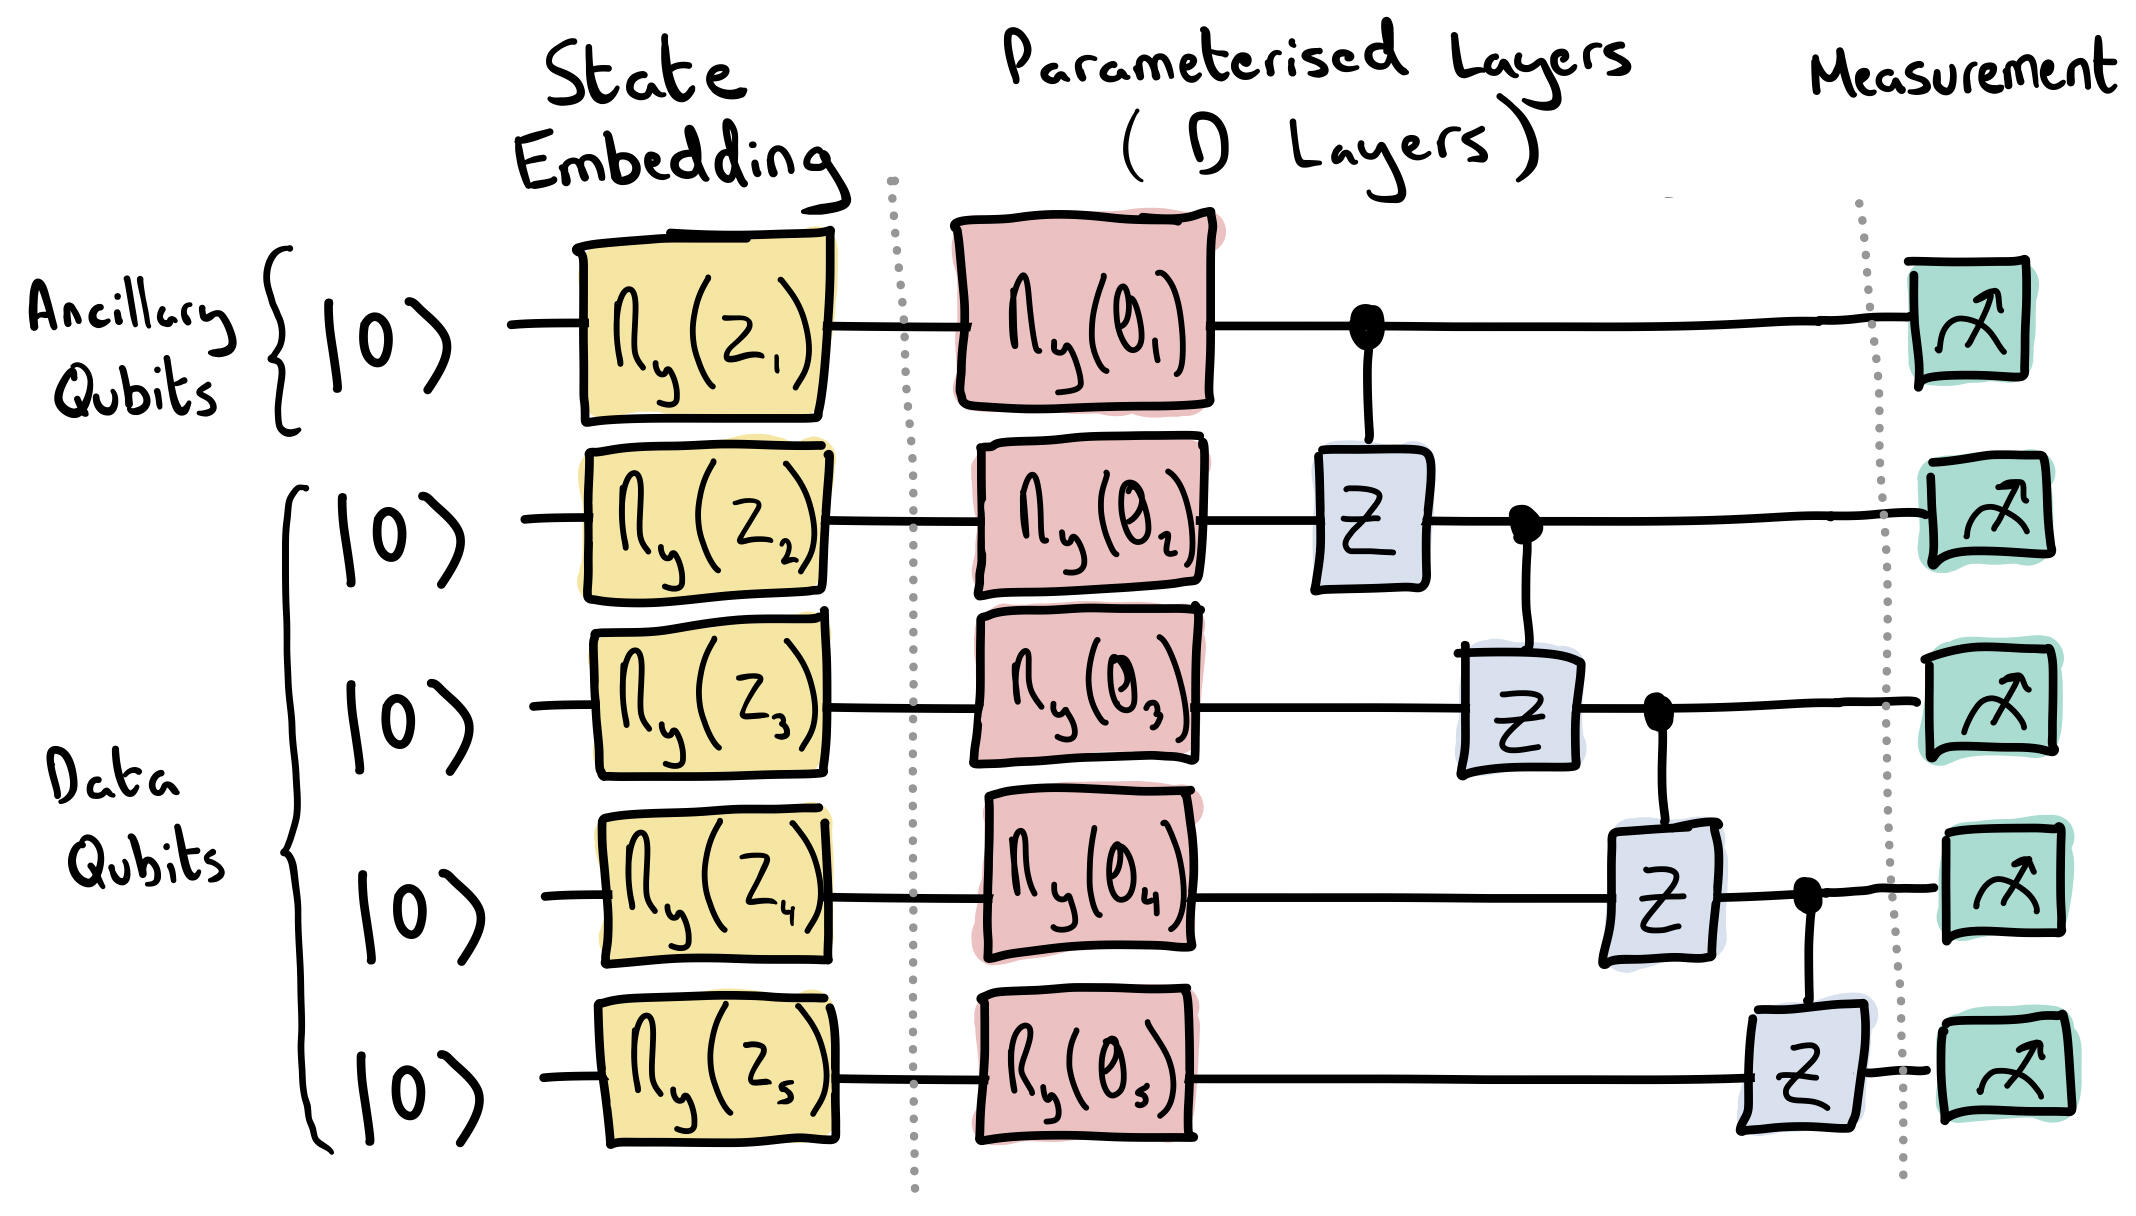

1) State Embedding

A latent vector, 
z
∈
R
N
, is sampled from a uniform distribution in the interval 
[
0
,
π
/
2
)
. All sub-generators receive the same latent vector which is then embedded using RY gates.

2) Parameterised Layers

The parameterised layer consists of parameterised RY gates followed by control Z gates. This layer is repeated 
D
 times in total.

3) Non-Linear Transform

Quantum gates in the circuit model are unitary which, by definition, linearly transform the quantum state. A linear mapping between the latent and generator distribution would be suffice for only the most simple generative tasks, hence we need non-linear transformations. We will use ancillary qubits to help.

For a given sub-generator, the pre-measurement quantum state is given by,

|Ψ(z)⟩=UG(θ)|z⟩ where UG(θ)
 represents the overall unitary of the parameterised layers. Let us inspect the state when we take a partial measurment, Π, and trace out the ancillary subsystem, A,
ρ(z)=TrA(Π⊗I|Ψ(z)⟩⟨Ψ(z)|)Tr(Π⊗I|Ψ(z)⟩⟨Ψ(z)|))=TrA(Π⊗I|Ψ(z)⟩⟨Ψ(z)|)⟨Ψ(z)|Π⊗I|Ψ(z⟩
The post-measurement state, 
ρ(z), is dependent on z
 in both the numerator and denominator. This means the state has been non-linearly transformed! For this we use, 
 Π=(|0⟩⟨0|)⊗NA, where NA is the number of ancillary qubits in the system.

With the remaining data qubits, we measure the probability of 
ρ(z)in each computational basis state, P(j), to obtain the sub-generator output, g(i),
g(i)=[P(0),P(1),...,P(2N−NA−1)]

4) Post Processing

Due to the normalisation constraint of the measurment, all elements in 
g(i) must sum to one. This is a problem if we are to use 
g(i) as the pixel intensity values for our patch. For example, imagine a hypothetical situation where a patch of full intensity pixels was the target. The best patch a sub-generator could produce would be a patch of pixels all at a magnitude of 
1
2N−NA
. To alleviate this constraint, we apply a post-processing technique to each patch,

~x(i)=g(i)maxkg(i)k
Therefore, the final image, 
~x, is given by
~
x=[~x(1),...,~x(NG)]

In [7]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G

Next, we define the quantum device we want to use, along 

In [8]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Next, we define the quantum circuit and measurement process defined describe above.

In [9]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

Now we create a quantum generator class to use during training.

In [10]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

###Training:- Let's define learning rates and number of iterations for the training process.

In [11]:
lrG = 0.3 #learning rate for the generator
lrD = 0.01 #learning rate for the discriminator
num_iter = 1000 #Number of training iterators 

Now putting everything together and executing the training process.

In [12]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.361, Generator Loss: 0.596
Iteration: 20, Discriminator Loss: 1.351, Generator Loss: 0.604
Iteration: 30, Discriminator Loss: 1.308, Generator Loss: 0.624
Iteration: 40, Discriminator Loss: 1.302, Generator Loss: 0.628
Iteration: 50, Discriminator Loss: 1.270, Generator Loss: 0.655
Iteration: 60, Discriminator Loss: 1.309, Generator Loss: 0.607
Iteration: 70, Discriminator Loss: 1.252, Generator Loss: 0.652
Iteration: 80, Discriminator Loss: 1.302, Generator Loss: 0.594
Iteration: 90, Discriminator Loss: 1.254, Generator Loss: 0.615
Iteration: 100, Discriminator Loss: 1.290, Generator Loss: 0.593
Iteration: 110, Discriminator Loss: 1.198, Generator Loss: 0.659
Iteration: 120, Discriminator Loss: 1.294, Generator Loss: 0.594
Iteration: 130, Discriminator Loss: 1.262, Generator Loss: 0.624
Iteration: 140, Discriminator Loss: 1.260, Generator Loss: 0.600
Iteration: 150, Discriminator Loss: 1.259, Generator Loss: 0.615
Iteration: 160, Discriminator Loss

IndexError: ignored

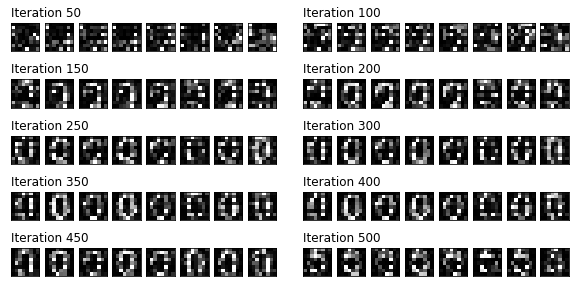

In [15]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()